In [31]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

d:\Semester6\AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 395M/395M [03:26<00:00, 2.00MB/s] 

Extracting files...


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\splcher\animefacedataset\versions\3


INFO:__main__:Loaded 5000 images across 5 classes.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


d:\Semester6\AI\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
INFO:__main__:Starting base training...


Epoch 1/20
125/125 - 759s - 6s/step - accuracy: 0.2171 - loss: 2.0387 - val_accuracy: 0.2794 - val_loss: 1.6065
Epoch 2/20
125/125 - 701s - 6s/step - accuracy: 0.2198 - loss: 1.8380 - val_accuracy: 0.2595 - val_loss: 1.6068
Epoch 3/20
125/125 - 563s - 5s/step - accuracy: 0.2273 - loss: 1.7330 - val_accuracy: 0.2116 - val_loss: 1.6090
Epoch 4/20
125/125 - 366s - 3s/step - accuracy: 0.2323 - loss: 1.6674 - val_accuracy: 0.2136 - val_loss: 1.6086


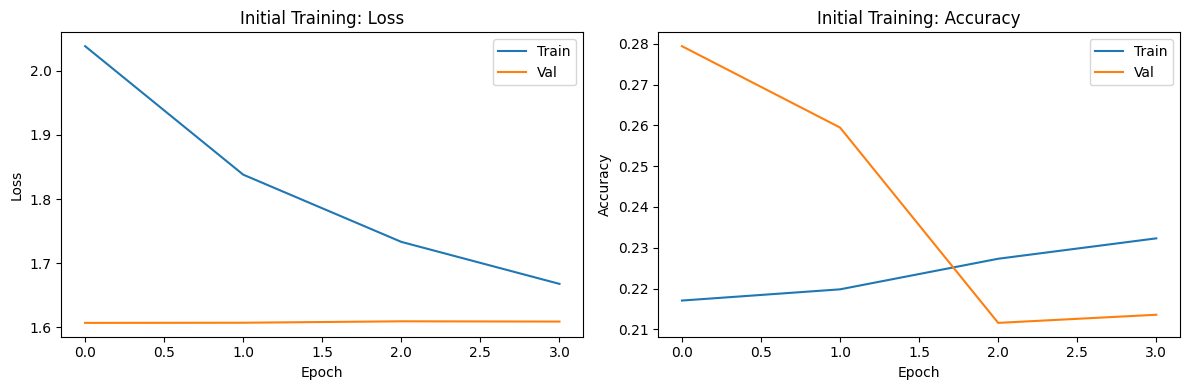

INFO:__main__:Fine-tuning...


Epoch 1/10
125/125 - 313s - 3s/step - accuracy: 0.2331 - loss: 1.8843 - val_accuracy: 0.2814 - val_loss: 1.6041
Epoch 2/10
125/125 - 304s - 2s/step - accuracy: 0.2263 - loss: 1.8499 - val_accuracy: 0.2774 - val_loss: 1.6009
Epoch 3/10
125/125 - 349s - 3s/step - accuracy: 0.2233 - loss: 1.8029 - val_accuracy: 0.2794 - val_loss: 1.5944
Epoch 4/10
125/125 - 322s - 3s/step - accuracy: 0.2246 - loss: 1.7782 - val_accuracy: 0.2894 - val_loss: 1.5879
Epoch 5/10
125/125 - 3374s - 27s/step - accuracy: 0.2266 - loss: 1.7488 - val_accuracy: 0.2814 - val_loss: 1.5836
Epoch 6/10


In [ ]:
import os
import time
import logging
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# ────────────── Config ──────────────
DATA_DIR = "./dataset"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
TEST_SIZE = 0.10
VAL_SIZE = 0.10
RANDOM_STATE = 42
MODEL_DIR = "./models"
LOG_DIR = "./logs"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# ────────────── Logging ──────────────
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
tf.keras.mixed_precision.set_global_policy("mixed_float16")


# ────────────── Dataset Utils ──────────────
def load_image_paths_and_labels(data_dir):
    classes = sorted(
        [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    )
    filepaths, labels = [], []
    for class_name in classes:
        for fname in os.listdir(os.path.join(data_dir, class_name)):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                filepaths.append(os.path.join(data_dir, class_name, fname))
                labels.append(class_name)
    logger.info(f"Loaded {len(filepaths)} images across {len(classes)} classes.")
    return filepaths, labels, classes


def make_datasets(filepaths, labels):
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    fp_trainval, fp_test, lb_trainval, lb_test = train_test_split(
        filepaths,
        labels_encoded,
        test_size=TEST_SIZE,
        stratify=labels_encoded,
        random_state=RANDOM_STATE,
    )
    val_fraction = VAL_SIZE / (1 - TEST_SIZE)
    fp_train, fp_val, lb_train, lb_val = train_test_split(
        fp_trainval,
        lb_trainval,
        test_size=val_fraction,
        stratify=lb_trainval,
        random_state=RANDOM_STATE,
    )

    def process(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    def augment(img, label):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return img, label

    def make_ds(fps, lbs, augment_data=False):
        ds = tf.data.Dataset.from_tensor_slices((fps, lbs))
        ds = ds.shuffle(buffer_size=len(fps), seed=RANDOM_STATE) if augment_data else ds
        ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
        if augment_data:
            ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    train_ds = make_ds(fp_train, lb_train, augment_data=True)
    val_ds = make_ds(fp_val, lb_val)
    test_ds = make_ds(fp_test, lb_test)

    np.save(os.path.join(MODEL_DIR, "class_names.npy"), le.classes_)
    return train_ds, val_ds, test_ds, len(le.classes_), le.classes_, lb_train


# ────────────── Model Building ──────────────
def build_model(num_classes, train_base=False):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = train_base

    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32"),
        ]
    )
    return model


def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    for i, metric in enumerate(["loss", "accuracy"]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history[f"val_{metric}"], label="Val")
        plt.title(f"{title}: {metric.capitalize()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()


# ────────────── Main ──────────────
def main():
    start = time.time()
    filepaths, labels, _ = load_image_paths_and_labels(DATA_DIR)
    train_ds, val_ds, test_ds, num_classes, class_names, lb_train = make_datasets(
        filepaths, labels
    )

    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", classes=np.unique(lb_train), y=lb_train
            )
        )
    )

    model = build_model(num_classes, train_base=False)
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, "best_model.keras"), save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    ]

    logger.info("Starting base training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )
    plot_history(history, "Initial Training")

    logger.info("Fine-tuning...")
    model.layers[1].trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )
    plot_history(history_fine, "Fine Tuning")

    logger.info("Evaluating on test set...")
    loss, acc = model.evaluate(test_ds, verbose=0)
    logger.info(f"Test loss: {loss:.4f} | accuracy: {acc:.4f}")

    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = np.argmax(model.predict(test_ds), axis=1)

    logger.info(
        "\n" + classification_report(y_true, y_pred, target_names=class_names.tolist())
    )
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
        cmap="Blues", xticks_rotation=45
    )
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    final_model_path = os.path.join(MODEL_DIR, "anime_face_model.keras")
    model.save(final_model_path)
    logger.info(f"Model saved to {final_model_path}")
    logger.info(f"Total training + evaluation time: {time.time() - start:.2f}s")


if __name__ == "__main__":
    main()

In [ ]:
import os
import time
import logging
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# ────────────── Config ──────────────
DATA_DIR = "./dataset"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
TEST_SIZE = 0.10
VAL_SIZE = 0.10
RANDOM_STATE = 42
MODEL_DIR = "./models"
LOG_DIR = "./logs"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# ────────────── Logging ──────────────
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
tf.keras.mixed_precision.set_global_policy("mixed_float16")


# ────────────── Dataset Utils ──────────────
def load_image_paths_and_labels(data_dir):
    classes = sorted(
        [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    )
    filepaths, labels = [], []
    for class_name in classes:
        for fname in os.listdir(os.path.join(data_dir, class_name)):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                filepaths.append(os.path.join(data_dir, class_name, fname))
                labels.append(class_name)
    logger.info(f"Loaded {len(filepaths)} images across {len(classes)} classes.")
    return filepaths, labels, classes


def make_datasets(filepaths, labels):
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    fp_trainval, fp_test, lb_trainval, lb_test = train_test_split(
        filepaths,
        labels_encoded,
        test_size=TEST_SIZE,
        stratify=labels_encoded,
        random_state=RANDOM_STATE,
    )
    val_fraction = VAL_SIZE / (1 - TEST_SIZE)
    fp_train, fp_val, lb_train, lb_val = train_test_split(
        fp_trainval,
        lb_trainval,
        test_size=val_fraction,
        stratify=lb_trainval,
        random_state=RANDOM_STATE,
    )

    def process(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    def augment(img, label):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return img, label

    def make_ds(fps, lbs, augment_data=False):
        ds = tf.data.Dataset.from_tensor_slices((fps, lbs))
        ds = ds.shuffle(buffer_size=len(fps), seed=RANDOM_STATE) if augment_data else ds
        ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
        if augment_data:
            ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    train_ds = make_ds(fp_train, lb_train, augment_data=True)
    val_ds = make_ds(fp_val, lb_val)
    test_ds = make_ds(fp_test, lb_test)

    np.save(os.path.join(MODEL_DIR, "class_names.npy"), le.classes_)
    return train_ds, val_ds, test_ds, len(le.classes_), le.classes_, lb_train


# ────────────── Model Building ──────────────
def build_model(num_classes, train_base=False):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = train_base

    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32"),
        ]
    )
    return model


def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    for i, metric in enumerate(["loss", "accuracy"]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history[f"val_{metric}"], label="Val")
        plt.title(f"{title}: {metric.capitalize()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()


# ────────────── Main ──────────────
def main():
    start = time.time()
    filepaths, labels, _ = load_image_paths_and_labels(DATA_DIR)
    train_ds, val_ds, test_ds, num_classes, class_names, lb_train = make_datasets(
        filepaths, labels
    )

    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", classes=np.unique(lb_train), y=lb_train
            )
        )
    )

    model = build_model(num_classes, train_base=False)
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, "best_model.keras"), save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    ]

    logger.info("Starting base training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )
    plot_history(history, "Initial Training")

    logger.info("Fine-tuning...")
    model.layers[1].trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )
    plot_history(history_fine, "Fine Tuning")

    logger.info("Evaluating on test set...")
    loss, acc = model.evaluate(test_ds, verbose=0)
    logger.info(f"Test loss: {loss:.4f} | accuracy: {acc:.4f}")

    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = np.argmax(model.predict(test_ds), axis=1)

    logger.info(
        "\n" + classification_report(y_true, y_pred, target_names=class_names.tolist())
    )
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
        cmap="Blues", xticks_rotation=45
    )
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    final_model_path = os.path.join(MODEL_DIR, "anime_face_model.keras")
    model.save(final_model_path)
    logger.info(f"Model saved to {final_model_path}")
    logger.info(f"Total training + evaluation time: {time.time() - start:.2f}s")


if __name__ == "__main__":
    main()

In [ ]:
pip install scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 2.4 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/11.1 MB 3.2 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.1 MB 3.8 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.1 MB 3.8 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.1 MB 2.8 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/11.1 MB 3.3 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.1 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.1 MB 2.8 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.1 MB 2.9 MB/s eta 0:00:03
   ------------------- -------------------- 5.5/11.1 MB 2.7 MB/s eta 0:00:03
   ---------------------- ----------------- 6.3/11.1 MB 2.7 MB/s eta 0:00:02
   ----------